# 1. Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import os
from os import listdir
from PIL import Image
import cv2
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

2024-02-14 13:57:00.709086: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Load Data

The data is organized into 279 folders, each labeled by patient ID. Each patient folder contains two subfolders. These subfolders are categorized images as IDC negative (labeled 0) and IDC positive (labeled 1) 

In [2]:
for f in os.listdir("/Users/annaparton/Desktop/Springboard/Breast_Cancer_Capstone_Project/images/IDC_regular_ps50_idx5")[1:10]:
    print(f)
#base_path = "../Springboard/Breast_Cancer_Capstone_Project/data/IDC_regular_ps50_idx5"
base_path='/Users/annaparton/Desktop/Springboard/Breast_Cancer_Capstone_Project/images/IDC_regular_ps50_idx5'
#listdir is used to get the list of all files and directories in the specified directory
folder = listdir(base_path)
len(folder)

10268
10257
8913
13613
8914
15510
10259
16165
10292


280

# 3. Data Wrangling and EDA

First step is to create a dataframe that contains patient_id, label (0 = no cancer, 1 = cancer) and image pathway. 

The data comes in one large folder that contains subfolders for each patient. Those subfolders are labeled by the patient id. Each patient folder contains two folders labeled "0", no cancer, or "1", cancer, which contains images for both. 

In [3]:
#defining a function to create a dataframe with the patient_id, label (0 = no cancer, 1 = cancer), and image path
def process_images(root_folder):
    image_data = []

    #listdir is used to get the list of all files and directories in the specified directory
    for patient_folder in os.listdir(root_folder):
        patient_path = os.path.join(root_folder, patient_folder)
        
        #to check whether the specified path is an existing directory or no
        if os.path.isdir(patient_path):
            
            for class_folder in os.listdir(patient_path):
                class_path = os.path.join(patient_path, class_folder)
                if os.path.isdir(class_path):
                    label = int(class_folder)  # subfolders are named 0 and 1
                    
                    for image_file in os.listdir(class_path):
                        image_path = os.path.join(class_path, image_file)
                        image_data.append({'Patient_ID': patient_folder, 'Label': label, 'Image_Path': image_path})

    return pd.DataFrame(image_data)


In [4]:
root_folder = "/Users/annaparton/Desktop/Springboard/Breast_Cancer_Capstone_Project/images/IDC_regular_ps50_idx5"  
image_dataframe = process_images(root_folder)
print(image_dataframe.head())
print(len(image_dataframe))

  Patient_ID  Label                                         Image_Path
0       9036      0  /Users/annaparton/Desktop/Springboard/Breast_C...
1       9036      0  /Users/annaparton/Desktop/Springboard/Breast_C...
2       9036      0  /Users/annaparton/Desktop/Springboard/Breast_C...
3       9036      0  /Users/annaparton/Desktop/Springboard/Breast_C...
4       9036      0  /Users/annaparton/Desktop/Springboard/Breast_C...
277524


In [5]:
#looking at just one full image_path 
image_dataframe.Image_Path[1]

'/Users/annaparton/Desktop/Springboard/Breast_Cancer_Capstone_Project/images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x2951_y951_class0.png'

From the plot below and the actual value counts, can see have more not cancer images (count: 198738) than cancer iamges (count: 78786).  

0    198738
1     78786
Name: Label, dtype: int64


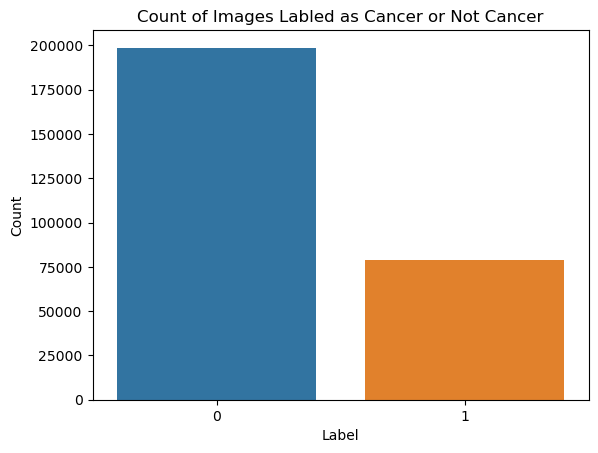

In [6]:
#plot to see how many images are labeled 0 or 1
sns.countplot(x='Label', data=image_dataframe)

#actual count of how many images are labeled 0 or 1
print(image_dataframe.Label.value_counts())
plt.title('Count of Images Labled as Cancer or Not Cancer')
plt.xlabel('Label')
plt.ylabel('Count')
plt.savefig('count_images_labels.png')
#plt.show()

In [7]:
image_dataframe.head()

,Patient_ID,Label,Image_Path
0,9036,0,/Users/annaparton/Desktop/Springboard/Breast_C...
1,9036,0,/Users/annaparton/Desktop/Springboard/Breast_C...
2,9036,0,/Users/annaparton/Desktop/Springboard/Breast_C...
3,9036,0,/Users/annaparton/Desktop/Springboard/Breast_C...
4,9036,0,/Users/annaparton/Desktop/Springboard/Breast_C...


Created a bar plot to show the number of images per patient as wanted to see the distribution. 

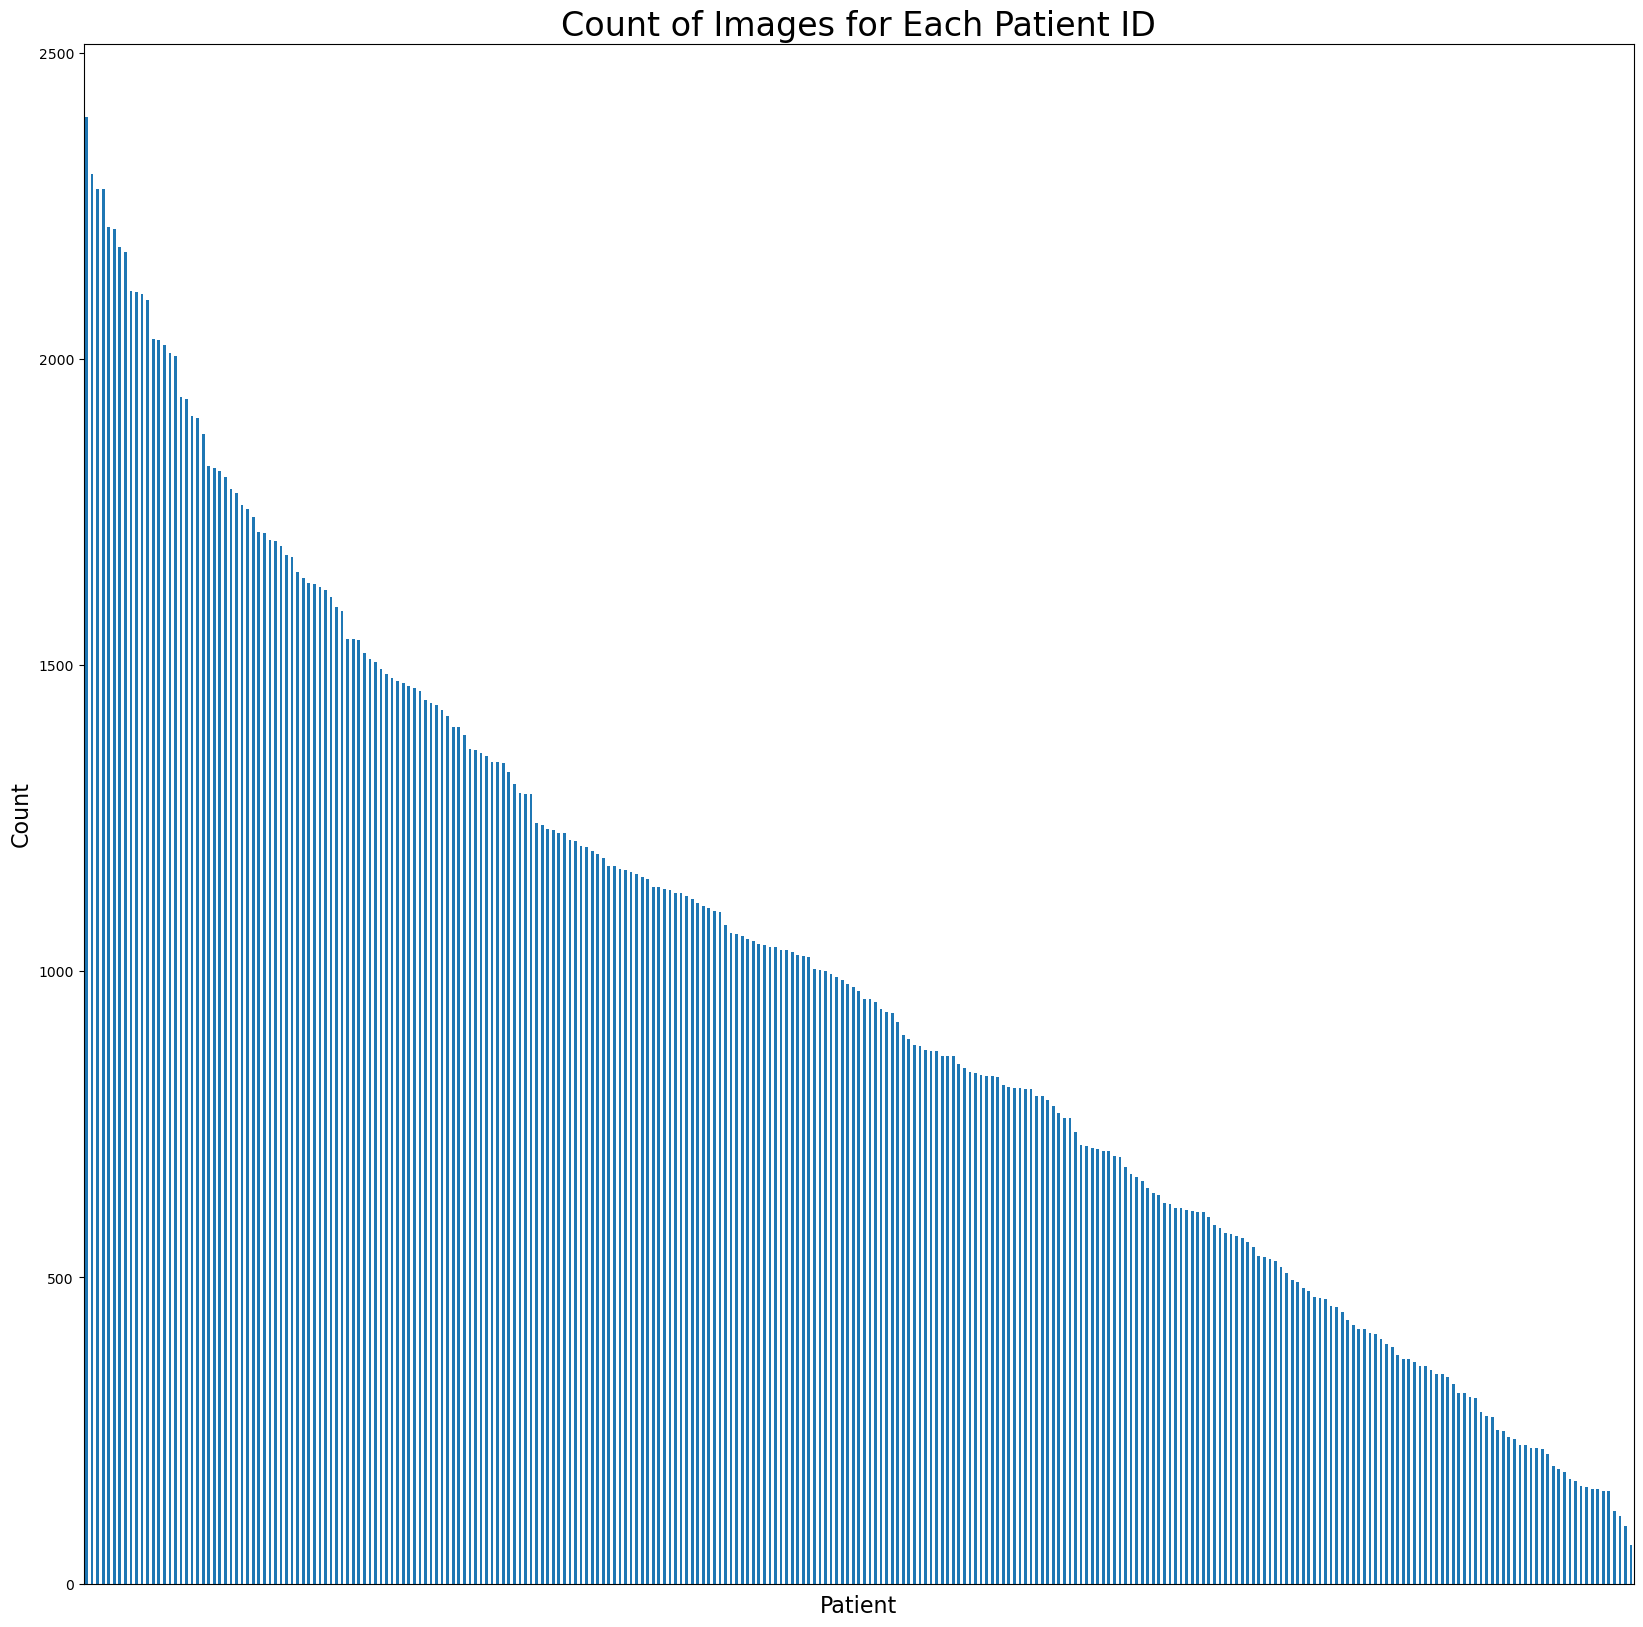

In [8]:
#actual count of how many images are labeled 0 or 1
patient_count_images= image_dataframe.Patient_ID.value_counts()

#quick glance to see if have the same number of patches for each patient
plt.figure(figsize=(20, 20))
patient_count_images.plot(kind='bar')
plt.title('Count of Images for Each Patient ID', fontsize=24)
plt.xticks([])  
plt.xlabel('Patient', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.savefig('count_images.png')
#plt.show()

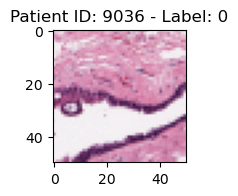

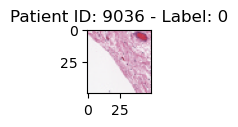

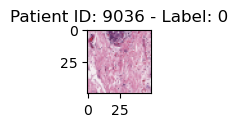

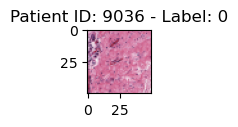

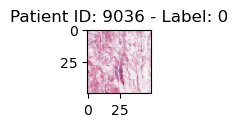

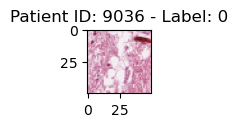

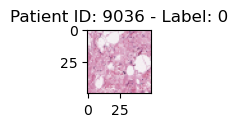

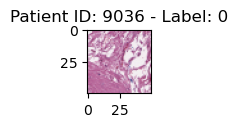

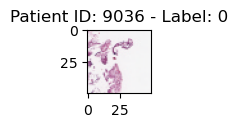

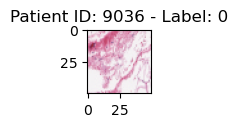

In [9]:
#plot the first 10 images (IDC negative)
plt.figure(figsize=(10,10))

for index, row in image_dataframe.head(10).iterrows() :
    #get contents for patient_id, label and image_path
    #iterrows used to iterate over a Pandas Dataframe rows in the form of (index, series) pair AND rows indices is called index
    image_path = row['Image_Path']
    label = row['Label']
    patient= row['Patient_ID']
    #plot images
    plt.subplot(5,5,index+1) 

    #Image.open = opens and identifies the given image file
    img = Image.open(image_path)

    #imshow from matplotlib library is used to display data as an image
    plt.imshow(img)
    plt.title(f'Patient ID: {patient} - Label: {label}')
    plt.show()


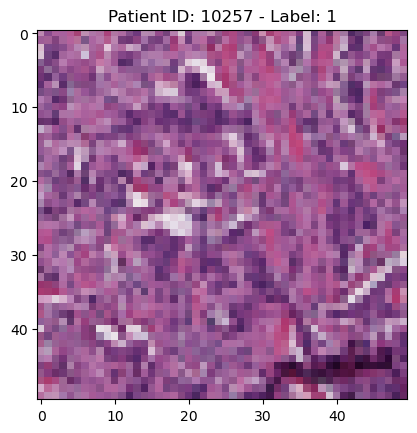

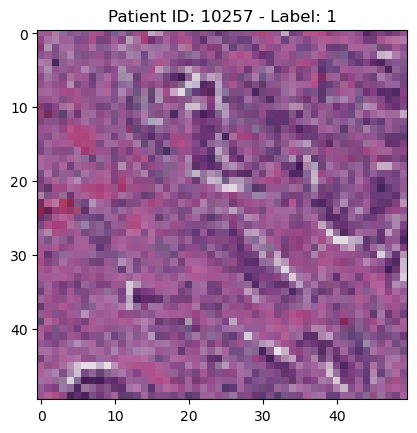

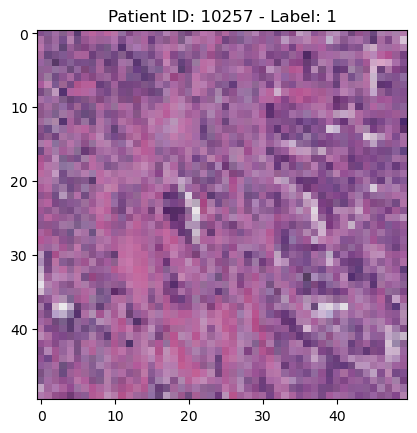

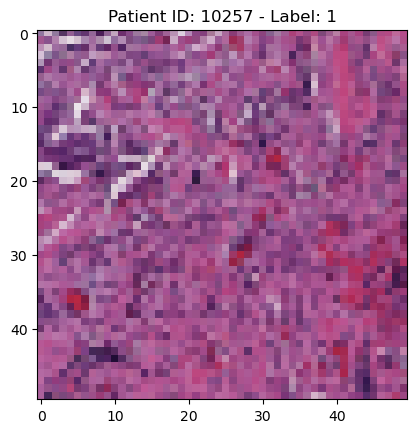

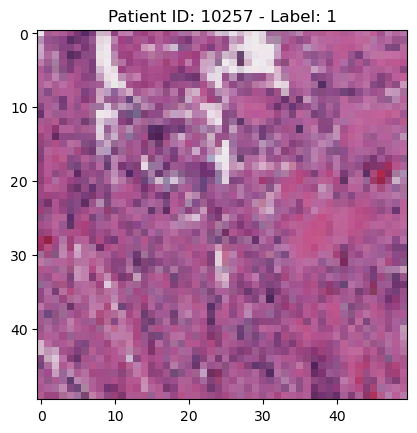

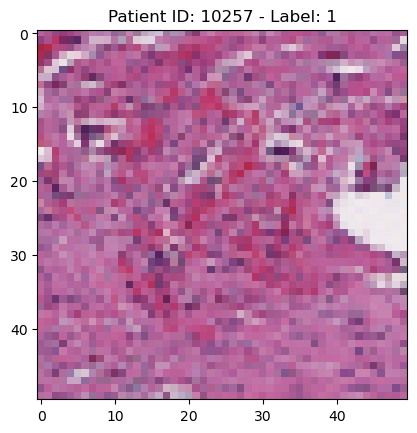

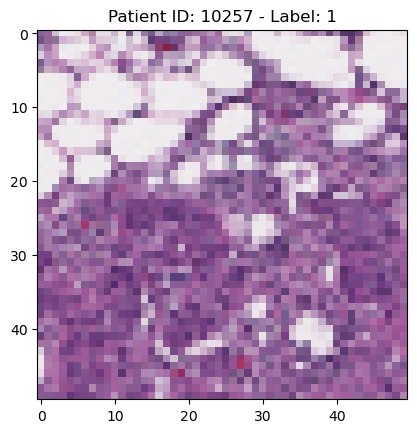

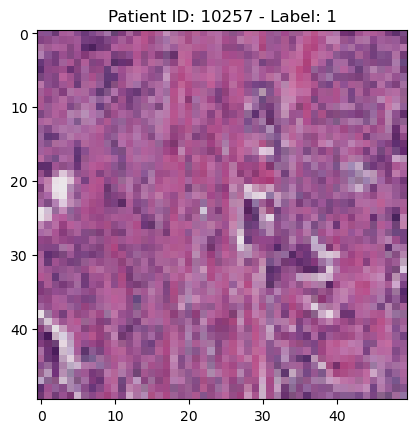

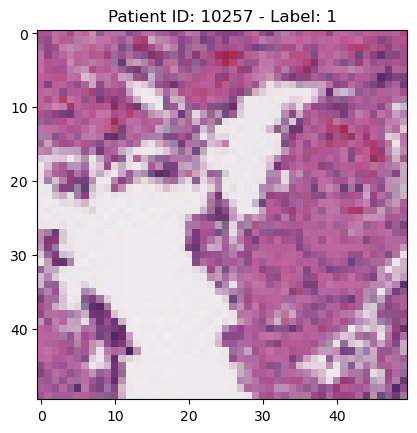

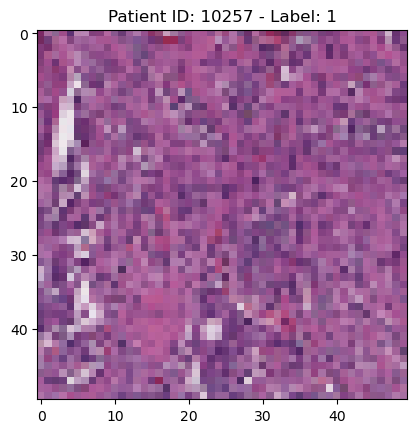

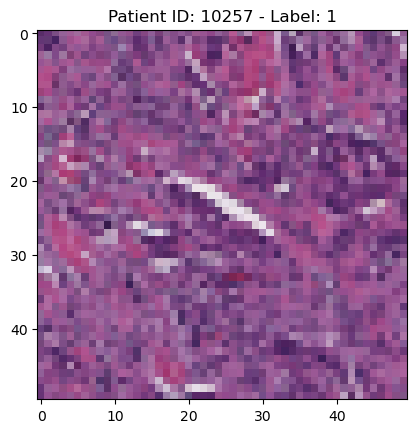

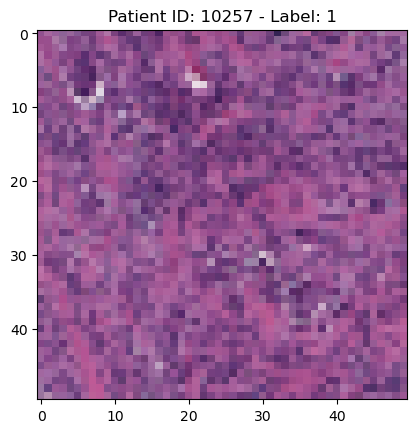

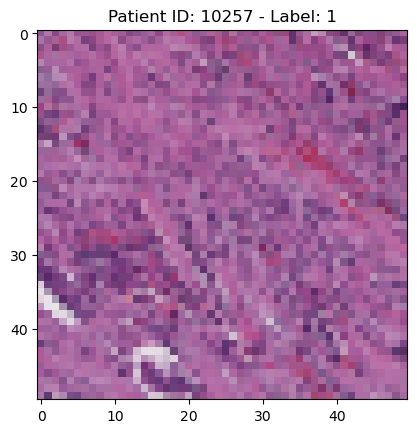

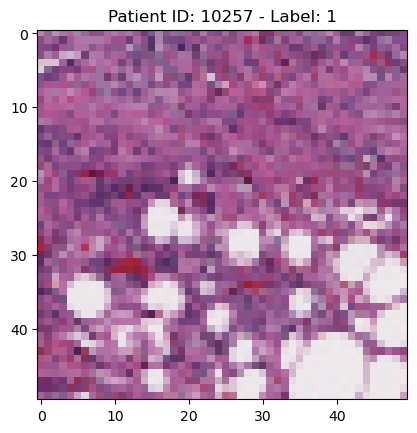

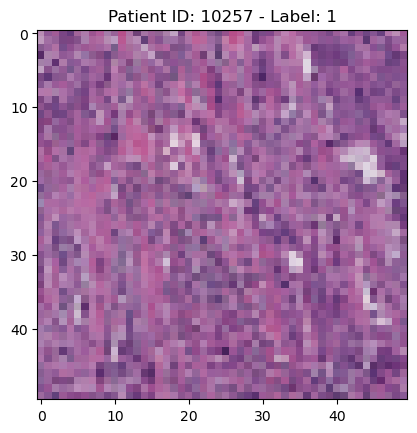

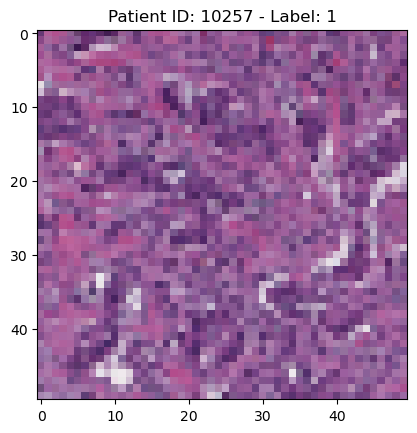

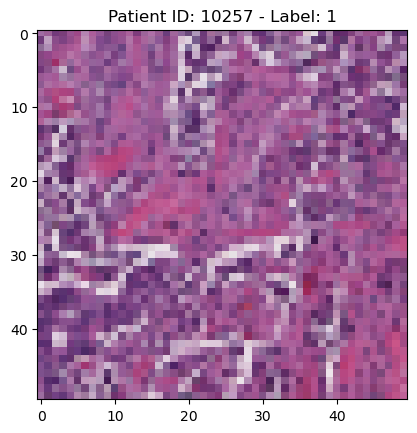

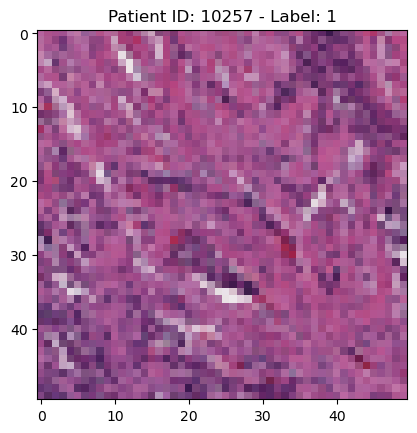

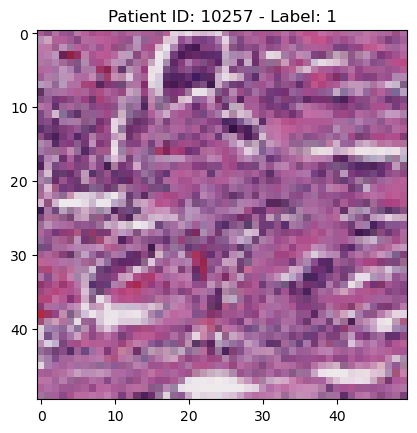

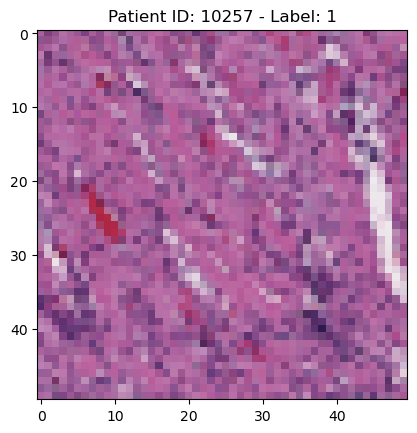

In [10]:
#plot 10 more images that are IDC positive
for index, row in image_dataframe[4000:4020].iterrows() :
    #get contents for patient_id, label and image_path 
    #iterrows used to iterate over a Pandas Dataframe rows in the form of (index, series) pair AND rows indices is called index
    image_path = row['Image_Path']
    label = row['Label']
    patient= row['Patient_ID']
    
    #plot images
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f'Patient ID: {patient} - Label: {label}')
    plt.show()


Randomly sampled and retained one-fourth of the dataset for further analysis.

In [12]:
# Select a portion of the data so not to crash (this will take a random sample)
fraction = 0.5
sampled_df = image_dataframe.sample(frac=fraction, random_state=42) 

In [13]:
sampled_df.head()

,Patient_ID,Label,Image_Path
226235,10304,0,/Users/annaparton/Desktop/Springboard/Breast_C...
152659,10291,0,/Users/annaparton/Desktop/Springboard/Breast_C...
261626,10282,0,/Users/annaparton/Desktop/Springboard/Breast_C...
124524,10272,0,/Users/annaparton/Desktop/Springboard/Breast_C...
82033,16896,1,/Users/annaparton/Desktop/Springboard/Breast_C...


# 4. Preprocess Data

## 4a Normalize images

In [14]:
# create function to normalize the images so pixel values are within the range of 0 to 1.
def preprocess_image(image_path):
    #loads an image from the specified file.
    img = cv2.imread(image_path)
    target_size = (50, 50)
    #sometimes resize image but really didn't have to do this
    img = cv2.resize(img, target_size)
    #changing values to be float and between 0 to 1
    img = img.astype(np.float32) / 255.0
    return img

In [15]:
#executing function above for column with 'Image_Path'
sampled_df['Processed_Image'] = sampled_df['Image_Path'].apply(preprocess_image)

In [16]:
#confirming there is no missing information
sampled_df.isna().sum()

Patient_ID         0
Label              0
Image_Path         0
Processed_Image    0
dtype: int64

## 4b Creating X and y for model

In [17]:
#create X, y to prepare the two classes (0 , 1) to be balanced
X= sampled_df.drop('Label', axis=1)
y= sampled_df['Label']
print(X.head())
print(y.value_counts())

       Patient_ID                                         Image_Path  \
226235      10304  /Users/annaparton/Desktop/Springboard/Breast_C...   
152659      10291  /Users/annaparton/Desktop/Springboard/Breast_C...   
261626      10282  /Users/annaparton/Desktop/Springboard/Breast_C...   
124524      10272  /Users/annaparton/Desktop/Springboard/Breast_C...   
82033       16896  /Users/annaparton/Desktop/Springboard/Breast_C...   

                                          Processed_Image  
226235  [[[0.8627451, 0.8156863, 0.85490197], [0.76862...  
152659  [[[0.77254903, 0.6627451, 0.79607844], [0.9019...  
261626  [[[0.5137255, 0.2901961, 0.8156863], [0.525490...  
124524  [[[0.9372549, 0.9254902, 0.9411765], [0.941176...  
82033   [[[0.59607846, 0.4392157, 0.73333335], [0.7764...  
0    99208
1    39554
Name: Label, dtype: int64


## 4c Balancing classes through resampling

The data is not balanced so will:
    1. Oversample the minority class to ~50% of the same amount as the majority
    2. Undersample the majority class to have equal amounts

In [18]:
#first will oversample
ros = RandomOverSampler(sampling_strategy=.45, random_state= 42)
X_over, y_over = ros.fit_resample(X, y)

0    99208
1    44643
Name: Label, dtype: int64


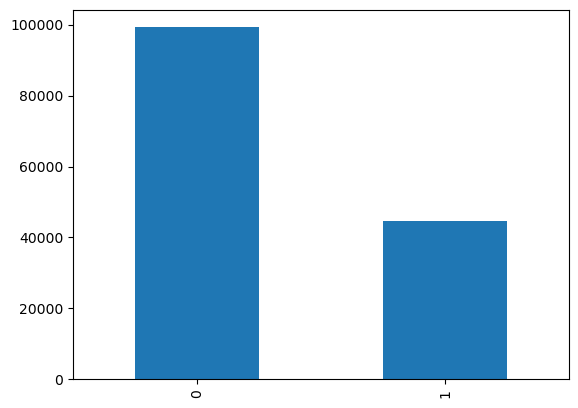

In [19]:
#plot to see how many images are labeled 0 or 1
y_over.value_counts().plot(kind='bar')
print(y_over.value_counts())

#values before this were {0: 99208, 1:39554}

In [20]:
#undersample the majority 
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_over, y_over)

0    44643
1    44643
Name: Label, dtype: int64


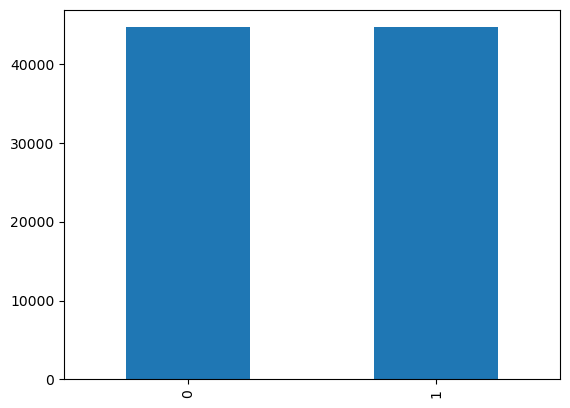

In [21]:
#plot to make sure now even
y_under.value_counts().plot(kind='bar')
print(y_under.value_counts())

#values before this were {0: 99208, 1: 44643}
#looking to use ~88000 instead of ~300000

In [22]:
X_image = X_under[['Processed_Image']]
print(type(X_image))
print(X_image.head())

<class 'pandas.core.frame.DataFrame'>
                                          Processed_Image
54122   [[[0.69803923, 0.5764706, 0.9098039], [0.67843...
121609  [[[0.8352941, 0.7647059, 0.83137256], [0.75294...
31499   [[[0.654902, 0.5411765, 0.8980392], [0.6156863...
62490   [[[0.63529414, 0.52156866, 0.8627451], [0.6784...
97438   [[[0.9098039, 0.8784314, 0.9372549], [0.686274...


## 4d Creating X matrix into a 4D numpy array to be ready for CNN model

Transformed images (pixel values) into numpy arrays, preparing them for the CNN model.
1. List comprehension - iterated over each entry in the 'Processed_Image' column, converting each 3D array into a NumPy array. 
2. The resulting list of NumPy arrays is then converted into a single NumPy array. This creates a 4D array (number of images, height, width, channels). 

In [23]:
#convert X_image into numpy array to be ready for CNN modeling
X_numpy = np.array([np.array(img) for img in X_image['Processed_Image']])

In [24]:
X_numpy[0:5]

array([[[[0.69803923, 0.5764706 , 0.9098039 ],
         [0.6784314 , 0.54509807, 0.9098039 ],
         [0.6745098 , 0.5568628 , 0.90588236],
         ...,
         [0.72156864, 0.5921569 , 0.8666667 ],
         [0.7254902 , 0.60784316, 0.77254903],
         [0.68235296, 0.5411765 , 0.7921569 ]],

        [[0.7137255 , 0.5803922 , 0.9137255 ],
         [0.69411767, 0.5686275 , 0.90588236],
         [0.69803923, 0.5411765 , 0.9019608 ],
         ...,
         [0.73333335, 0.6117647 , 0.85882354],
         [0.6392157 , 0.4862745 , 0.73333335],
         [0.63529414, 0.46666667, 0.69803923]],

        [[0.69411767, 0.57254905, 0.90588236],
         [0.7411765 , 0.63529414, 0.89411765],
         [0.73333335, 0.63529414, 0.8980392 ],
         ...,
         [0.72156864, 0.5882353 , 0.87058824],
         [0.62352943, 0.48235294, 0.72156864],
         [0.627451  , 0.4627451 , 0.6862745 ]],

        ...,

        [[0.6862745 , 0.56078434, 0.84313726],
         [0.75686276, 0.6392157 , 0.88235295]

Split the data into training and testing datasets. Will use .1 of the training data as validation data. 

## 4e Splitting data into training and testing datasets

In [25]:
#first split the data into training (.8) and testing (.2)
X_train, X_test, y_train, y_test = train_test_split(X_numpy, y_under, test_size=0.2, random_state=1)

In [26]:
# (71428, 50, 50, 3) refers to (number_of_images, height, width, channels) where 3 channels means red, green and blue
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(71428, 50, 50, 3)
(71428,)
(17858, 50, 50, 3)


# 5. Model

## 5a CNN Model 

In [94]:
#Model 1
model = Sequential()

In [95]:
from keras.regularizers import l1, l2
#convolution layers with rectified linear unit (ReLU) as activation function then followed by maxpooling layers
#maxpooling reduces dimensionality while retaining crucial information.
model.add(Conv2D(8, (2,2), 1, activation='relu', input_shape=(50,50,3)))
model.add(MaxPooling2D())
#model.add(Dropout(0.2)) 
model.add(Conv2D(8, (2,2), 1, activation='relu'))
model.add(MaxPooling2D())
#model.add(Dropout(0.2)) 
model.add(Conv2D(8, (2,2), 1, activation='relu'))
model.add(MaxPooling2D())

#flatten output into one large vector that will feed into the fully connected layer (hidden layer)
model.add(Flatten())

#fully connected classifier
#Dense refers "fully connected layer"
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))

#use sigmoid function as detecting if IDC positive
model.add(Dense(1, activation='sigmoid'))

In [96]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report

#used the 'adam' optimizer due to having a faster computation time and generally performs well
#Binary cross-entropy loss is used for binary (0 or 1) classification tasks
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [97]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 49, 49, 8)         104       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 24, 24, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 23, 23, 8)         264       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 11, 11, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 10, 10, 8)         264       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 5, 5, 8)         

In [98]:
#fit the model to the data and use validation_split argument to section off
history = model.fit(X_train, y_train, epochs=20, validation_split=0.1)

Epoch 1/20
2009/2009 [==============================] - 15s 7ms/step - loss: 0.5624 - accuracy: 0.7569 - val_loss: 0.4718 - val_accuracy: 0.7985
Epoch 2/20
2009/2009 [==============================] - 13s 7ms/step - loss: 0.4618 - accuracy: 0.8000 - val_loss: 0.4705 - val_accuracy: 0.7955
Epoch 3/20
2009/2009 [==============================] - 13s 7ms/step - loss: 0.4406 - accuracy: 0.8111 - val_loss: 0.4356 - val_accuracy: 0.8176
Epoch 4/20
2009/2009 [==============================] - 14s 7ms/step - loss: 0.4291 - accuracy: 0.8156 - val_loss: 0.4302 - val_accuracy: 0.8181
Epoch 5/20
2009/2009 [==============================] - 15s 7ms/step - loss: 0.4248 - accuracy: 0.8181 - val_loss: 0.4683 - val_accuracy: 0.8008
Epoch 6/20
2009/2009 [==============================] - 15s 7ms/step - loss: 0.4190 - accuracy: 0.8214 - val_loss: 0.4570 - val_accuracy: 0.8085
Epoch 7/20
2009/2009 [==============================] - 15s 7ms/step - loss: 0.4176 - accuracy: 0.8204 - val_loss: 0.4213 - val_ac

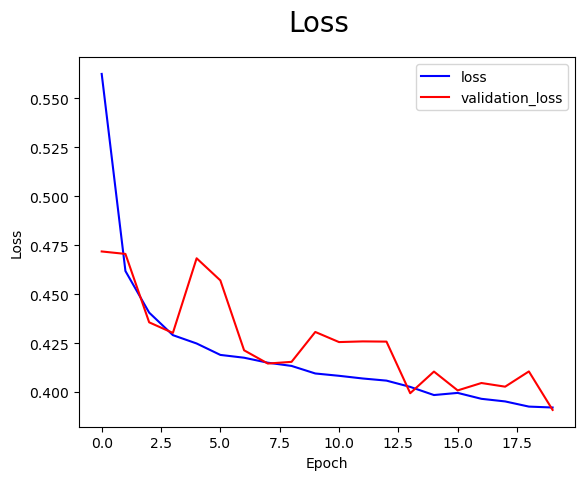

In [99]:
#plotting the loss for training and validation data
fig = plt.figure()
plt.plot(history.history['loss'], color='blue', label='loss')
plt.plot(history.history['val_loss'], color='red', label='validation_loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.savefig('loss.png')
#plt.show()

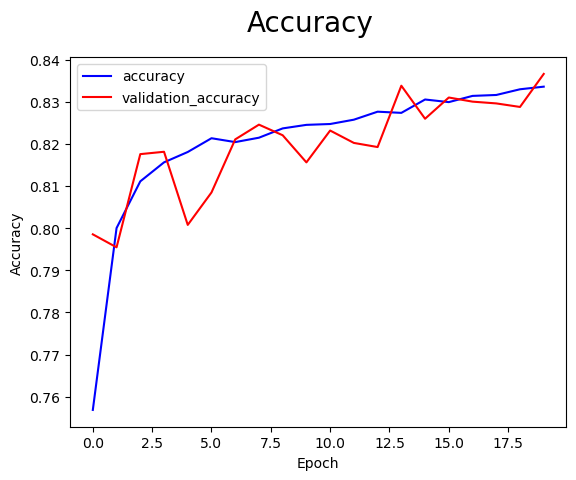

In [101]:
#plotting the accuracy for training and validation data
fig = plt.figure()
plt.plot(history.history['accuracy'], color='blue', label='accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.savefig('accuracy.png')
#plt.show()

In [102]:
#what is the loss and accuracy of the testing data
score = model.evaluate(X_test, y_test, verbose = 0 )
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  0.378774493932724
Test accuracy:  0.8389517068862915


Plotting the ROC curve and finding the AUC score for model as better metrics than accuracy and loss for this data. 

In [103]:
from sklearn.metrics import roc_curve
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

559/559 [==============================] - 2s 3ms/step


In [104]:
from sklearn.metrics import auc
auc_model1 = auc(fpr, tpr)
auc_model1

0.9149406866743115

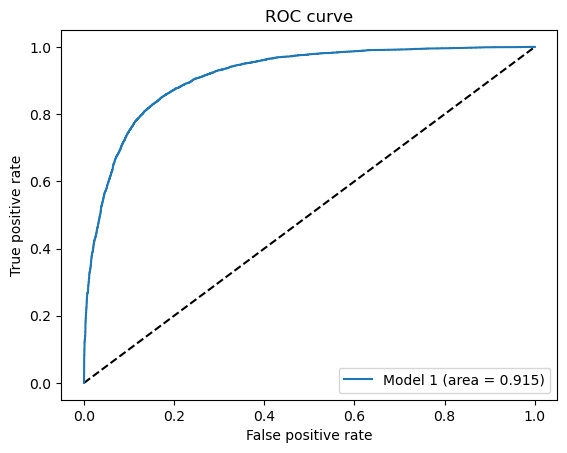

In [105]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Model 1 (area = {:.3f})'.format(auc_model1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## 5b - CNN Model with changes to layers

In [106]:
model2 = Sequential()

In [107]:
#building layers
model2.add(Conv2D(8, (2,2), 1, activation='relu', input_shape=(50,50,3)))
model2.add(MaxPooling2D())
model2.add(Conv2D(16, (2,2), 1, activation='relu'))
model2.add(MaxPooling2D())
model2.add(Conv2D(8, (2,2), 1, activation='relu'))
model2.add(MaxPooling2D())

#flatten output
model2.add(Flatten())
#fully connected classifier
model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [108]:
model2.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [109]:
#fit the model to the data and use validation_split argument to section off
history2 = model2.fit(X_train, y_train, epochs=20, validation_split=0.1)

Epoch 1/20
2009/2009 [==============================] - 15s 7ms/step - loss: 0.4795 - accuracy: 0.7809 - val_loss: 0.4395 - val_accuracy: 0.8026
Epoch 2/20
2009/2009 [==============================] - 14s 7ms/step - loss: 0.4355 - accuracy: 0.8042 - val_loss: 0.4354 - val_accuracy: 0.8011
Epoch 3/20
2009/2009 [==============================] - 14s 7ms/step - loss: 0.4196 - accuracy: 0.8113 - val_loss: 0.4101 - val_accuracy: 0.8207
Epoch 4/20
2009/2009 [==============================] - 15s 8ms/step - loss: 0.4004 - accuracy: 0.8221 - val_loss: 0.3957 - val_accuracy: 0.8228
Epoch 5/20
2009/2009 [==============================] - 16s 8ms/step - loss: 0.3927 - accuracy: 0.8275 - val_loss: 0.3855 - val_accuracy: 0.8314
Epoch 6/20
2009/2009 [==============================] - 16s 8ms/step - loss: 0.3812 - accuracy: 0.8346 - val_loss: 0.3834 - val_accuracy: 0.8313
Epoch 7/20
2009/2009 [==============================] - 16s 8ms/step - loss: 0.3768 - accuracy: 0.8363 - val_loss: 0.4351 - val_ac

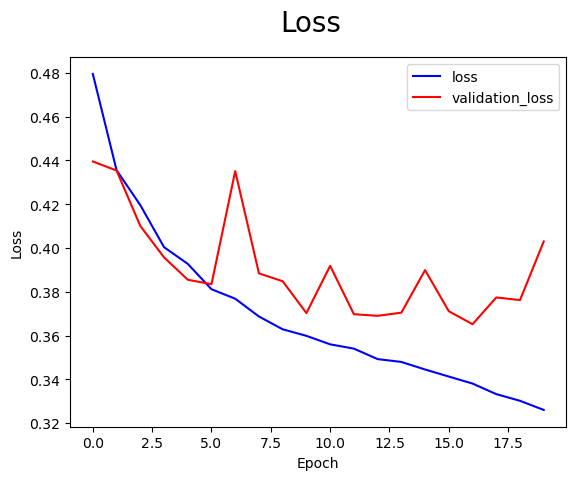

In [111]:
#plotting the loss for training and validation data for model 2
fig = plt.figure()
plt.plot(history2.history['loss'], color='blue', label='loss')
plt.plot(history2.history['val_loss'], color='red', label='validation_loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.savefig('loss-model2.png')
#plt.show()

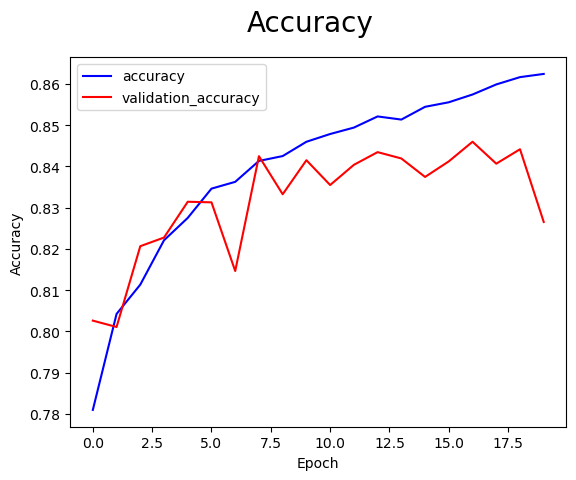

In [112]:
#plotting the accuracy for training and validation data for model 2
fig = plt.figure()
plt.plot(history2.history['accuracy'], color='blue', label='accuracy')
plt.plot(history2.history['val_accuracy'], color='red', label='validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
#plt.show()
plt.savefig('accuracy-model2.png')

In [113]:
score2 = model2.evaluate(X_test, y_test, verbose = 0 )
print("Test loss: ", score2[0])
print("Test accuracy: ", score2[1])

Test loss:  0.38959646224975586
Test accuracy:  0.8320080637931824


In [114]:
#getting values to plot ROC curve
y_pred2 = model2.predict(X_test).ravel()
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred2)

559/559 [==============================] - 2s 3ms/step


In [115]:
#AUC metric 
auc_model2 = auc(fpr2, tpr2)
auc_model2

0.9192435124727155

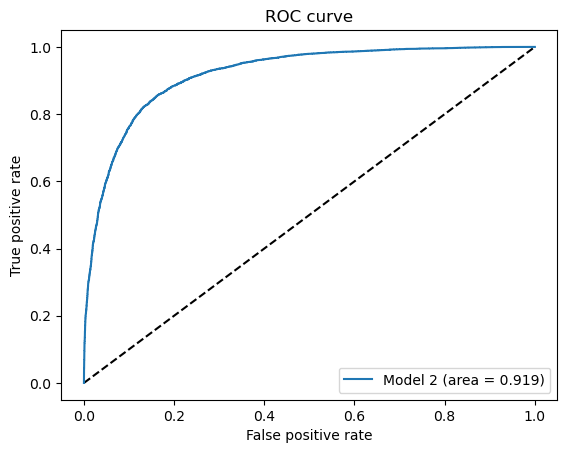

In [116]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr2, tpr2, label='Model 2 (area = {:.3f})'.format(auc_model2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('roc-curve-model2.png')
#plt.show()

## 5c Image Augmentation with CNN

In [117]:
image_generator = ImageDataGenerator(rotation_range=30, horizontal_flip=True)

In [118]:
model3 = Sequential()

In [119]:
#building layers
model3.add(Conv2D(8, (2,2), 1, activation='relu', input_shape=(50,50,3)))
model3.add(MaxPooling2D())
model3.add(Conv2D(8, (2,2), 1, activation='relu'))
model3.add(MaxPooling2D()) 
model3.add(Conv2D(8, (2,2), 1, activation='relu'))
model3.add(MaxPooling2D())

#flatten output into one large vector that will feed into the fully connected layer (hidden layer)
model3.add(Flatten())

#fully connected classifier
model3.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))

#use sigmoid function as detecting if IDC positive
model3.add(Dense(1, activation='sigmoid'))

In [120]:
model3.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 49, 49, 8)         104       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 24, 24, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 23, 23, 8)         264       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 11, 11, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 10, 10, 8)         264       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 5, 5, 8)        

In [125]:
augmented_data = image_generator.flow(X_train, y_train, batch_size=32)

TypeError: ImageDataGenerator.flow() got an unexpected keyword argument 'validation_split'

In [126]:
history3 = model3.fit(augmented_data, epochs=20, steps_per_epoch=len(X_train) // 32)

Epoch 1/20
2232/2232 [==============================] - 44s 20ms/step - loss: 0.4433 - accuracy: 0.8075
Epoch 2/20
2232/2232 [==============================] - 49s 22ms/step - loss: 0.4324 - accuracy: 0.8130
Epoch 3/20
2232/2232 [==============================] - 48s 22ms/step - loss: 0.4227 - accuracy: 0.8191
Epoch 4/20
2232/2232 [==============================] - 48s 22ms/step - loss: 0.4179 - accuracy: 0.8198
Epoch 5/20
2232/2232 [==============================] - 48s 22ms/step - loss: 0.4140 - accuracy: 0.8223
Epoch 6/20
2232/2232 [==============================] - 49s 22ms/step - loss: 0.4092 - accuracy: 0.8247
Epoch 7/20
2232/2232 [==============================] - 51s 23ms/step - loss: 0.4045 - accuracy: 0.8265
Epoch 8/20
2232/2232 [==============================] - 50s 23ms/step - loss: 0.4038 - accuracy: 0.8282
Epoch 9/20
2232/2232 [==============================] - 50s 22ms/step - loss: 0.4033 - accuracy: 0.8274
Epoch 10/20
2232/2232 [==============================] - 49s 22m

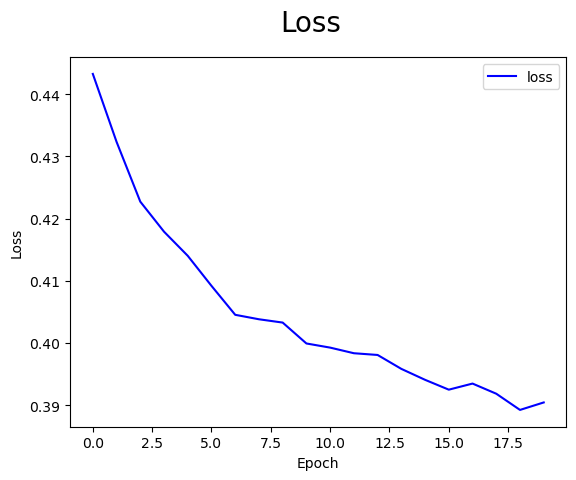

In [128]:
#plotting the loss for training and validation data for model 3
fig = plt.figure()
plt.plot(history3.history['loss'], color='blue', label='loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper right")
#plt.savefig('loss-model2.png')
plt.show()

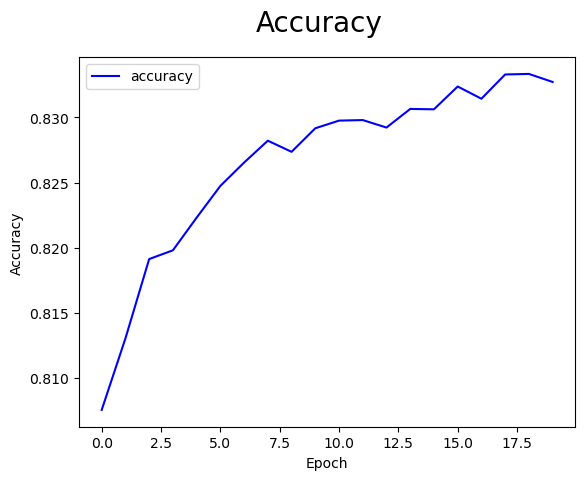

In [129]:
#plotting the accuracy for training and validation data for model 2
fig = plt.figure()
plt.plot(history3.history['accuracy'], color='blue', label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
#plt.show()
plt.savefig('accuracy-model2.png')

In [130]:
score3 = model3.evaluate(X_test, y_test, verbose = 0 )
print("Test loss: ", score3[0])
print("Test accuracy: ", score3[1])

Test loss:  0.38273918628692627
Test accuracy:  0.8359838724136353


In [131]:
#getting values to plot ROC curve
y_pred3 = model3.predict(X_test).ravel()
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred3)

559/559 [==============================] - 2s 3ms/step


In [132]:
#AUC metric 
auc_model3 = auc(fpr3, tpr3)
auc_model3

0.9124180978783543

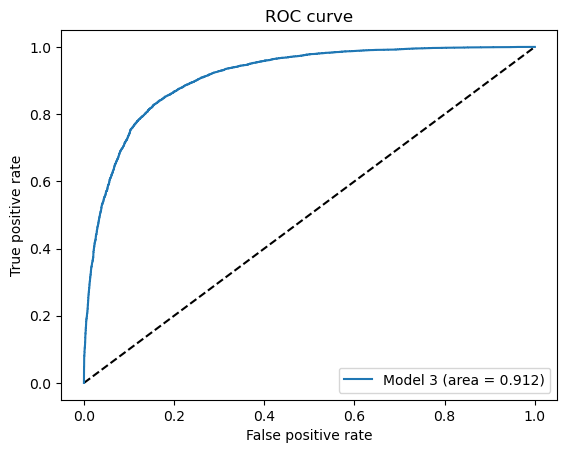

In [133]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr3, tpr3, label='Model 3 (area = {:.3f})'.format(auc_model3))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('roc-curve-model3.png')
#plt.show()

## 5d Pre-trained Transfer Learning - VGG16

In [74]:
from keras.applications import VGG16

In [134]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

In [135]:
for layer in vgg16.layers:
    layer.trainable = False

# Add new layers on top of the VGG16 model
model = Sequential([
    vgg16,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [136]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [138]:
history_vgg16 = model.fit(X_train, y_train, epochs=20, validation_split=0.1)

Epoch 1/20
2009/2009 [==============================] - 975s 485ms/step - loss: 0.4506 - accuracy: 0.7954 - val_loss: 0.4416 - val_accuracy: 0.7999
Epoch 2/20
2009/2009 [==============================] - 1002s 499ms/step - loss: 0.4352 - accuracy: 0.8040 - val_loss: 0.4416 - val_accuracy: 0.8004
Epoch 3/20
2009/2009 [==============================] - 1021s 508ms/step - loss: 0.4269 - accuracy: 0.8063 - val_loss: 0.4337 - val_accuracy: 0.8054
Epoch 4/20
2009/2009 [==============================] - 1009s 502ms/step - loss: 0.4171 - accuracy: 0.8148 - val_loss: 0.4275 - val_accuracy: 0.8097
Epoch 5/20
2009/2009 [==============================] - 1006s 501ms/step - loss: 0.4129 - accuracy: 0.8162 - val_loss: 0.4339 - val_accuracy: 0.8074
Epoch 6/20
2009/2009 [==============================] - 1007s 501ms/step - loss: 0.4055 - accuracy: 0.8209 - val_loss: 0.4286 - val_accuracy: 0.8065
Epoch 7/20
2009/2009 [==============================] - 1003s 499ms/step - loss: 0.4004 - accuracy: 0.8228 

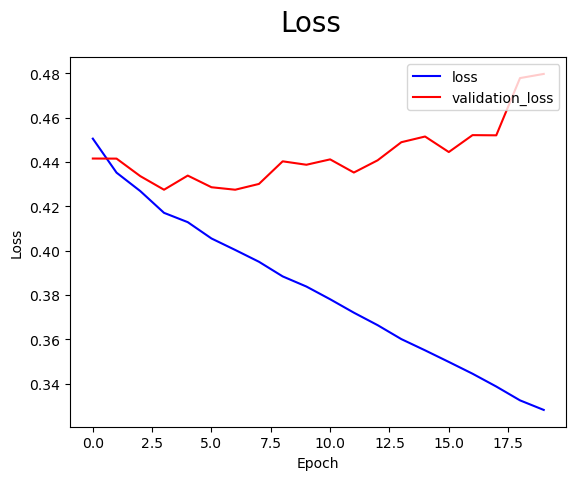

In [139]:
#plotting the loss for training and validation data for model with vgg16
fig = plt.figure()
plt.plot(history_vgg16.history['loss'], color='blue', label='loss')
plt.plot(history_vgg16.history['val_loss'], color='red', label='validation_loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper right")
#plt.savefig('loss-model_vgg16.png')
plt.show()

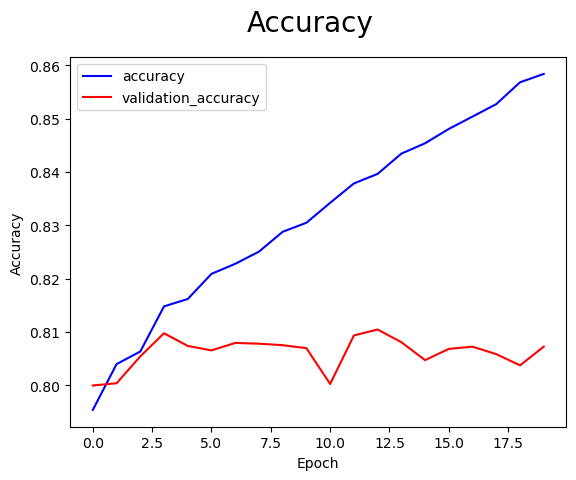

In [140]:
#plotting the accuracy for training and validation data for model with vgg16
fig = plt.figure()
plt.plot(history_vgg16.history['accuracy'], color='blue', label='accuracy')
plt.plot(history_vgg16.history['val_accuracy'], color='red', label='validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()
#plt.savefig('accuracy-model_vgg16.png')

In [141]:
score_vgg16 = model.evaluate(X_test, y_test, verbose = 0 )
print("Test loss: ", score_vgg16[0])
print("Test accuracy: ", score_vgg16[1])

Test loss:  0.465778648853302
Test accuracy:  0.8137529492378235


In [168]:
y_pred_vgg16 = model.predict(X_test).ravel()
fpr3, tpr3, thresholds2 = roc_curve(y_test, y_pred_vgg16)

#AUC metric 
auc_model_vgg16 = auc(fpr3, tpr3)
auc_model_vgg16

559/559 [==============================] - 219s 391ms/step


0.8849653175946299

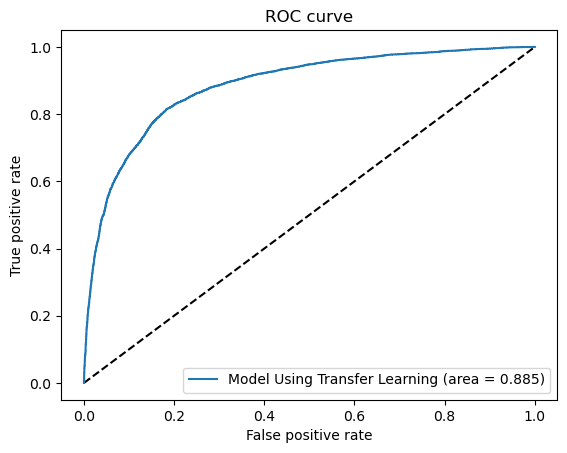

In [144]:
#plot ROC curve for VGG16
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr3, tpr3, label='Model Using Transfer Learning (area = {:.3f})'.format(auc_model_vgg16))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
#plt.savefig('roc-curve-model_vgg16.png')
plt.show()

## 5e Pre-trained Transfer Learning - Resnet

In [87]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create transfer learning model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pre-trained layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/Applications/anaconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [88]:
# Train the model
history_resnet= model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
2009/2009 [==============================] - 423s 210ms/step - loss: 0.6121 - accuracy: 0.6674 - val_loss: 0.5662 - val_accuracy: 0.7175
Epoch 2/20
2009/2009 [==============================] - 478s 238ms/step - loss: 0.5666 - accuracy: 0.7118 - val_loss: 0.5512 - val_accuracy: 0.7264
Epoch 3/20
2009/2009 [==============================] - 453s 226ms/step - loss: 0.5574 - accuracy: 0.7210 - val_loss: 0.5449 - val_accuracy: 0.7318
Epoch 4/20
2009/2009 [==============================] - 457s 228ms/step - loss: 0.5508 - accuracy: 0.7271 - val_loss: 0.5355 - val_accuracy: 0.7364
Epoch 5/20
2009/2009 [==============================] - 462s 230ms/step - loss: 0.5466 - accuracy: 0.7293 - val_loss: 0.5353 - val_accuracy: 0.7339
Epoch 6/20
2009/2009 [==============================] - 465s 232ms/step - loss: 0.5463 - accuracy: 0.7301 - val_loss: 0.5447 - val_accuracy: 0.7309
Epoch 7/20
2009/2009 [==============================] - 489s 243ms/step - loss: 0.5441 - accuracy: 0.7315 - val_

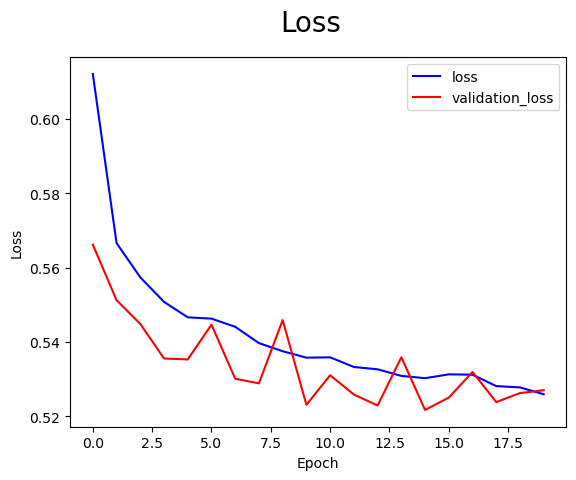

In [89]:
#plotting the loss for training and validation data for model with resnet
fig = plt.figure()
plt.plot(history_resnet.history['loss'], color='blue', label='loss')
plt.plot(history_resnet.history['val_loss'], color='red', label='validation_loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper right")
#plt.savefig('loss-model_vgg16.png')
plt.show()

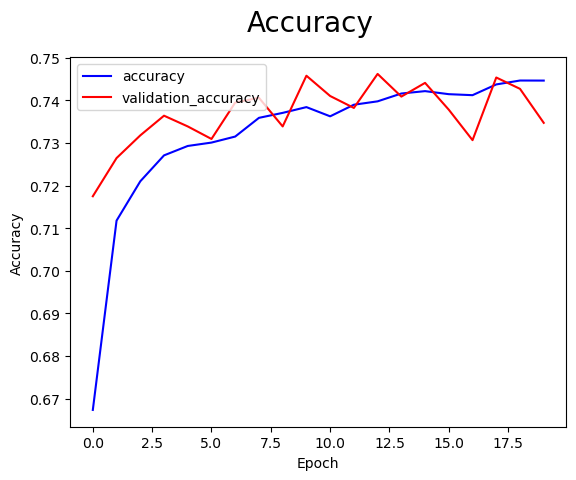

In [90]:
#plotting the accuracy for training and validation data for model with resnet
fig = plt.figure()
plt.plot(history_resnet.history['accuracy'], color='blue', label='accuracy')
plt.plot(history_resnet.history['val_accuracy'], color='red', label='validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()
#plt.savefig('accuracy-model_vgg16.png')

In [91]:
score_resnet = model.evaluate(X_test, y_test, verbose = 0 )
print("Test loss: ", score_resnet[0])
print("Test accuracy: ", score_resnet[1])

Test loss:  0.5297452807426453
Test accuracy:  0.7388845086097717


In [92]:
y_pred_resnet = model.predict(X_test).ravel()
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_resnet)

#AUC metric 
auc_model_resnet = auc(fpr2, tpr2)
auc_model_resnet

559/559 [==============================] - 113s 200ms/step


0.8206665870198969

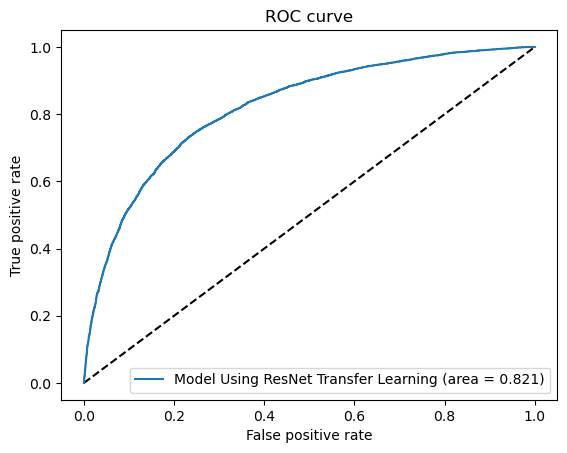

In [93]:
#plot ROC curve for resnet
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr2, tpr2, label='Model Using ResNet Transfer Learning (area = {:.3f})'.format(auc_model_resnet))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
#plt.savefig('roc-curve-model_vgg16.png')
plt.show()

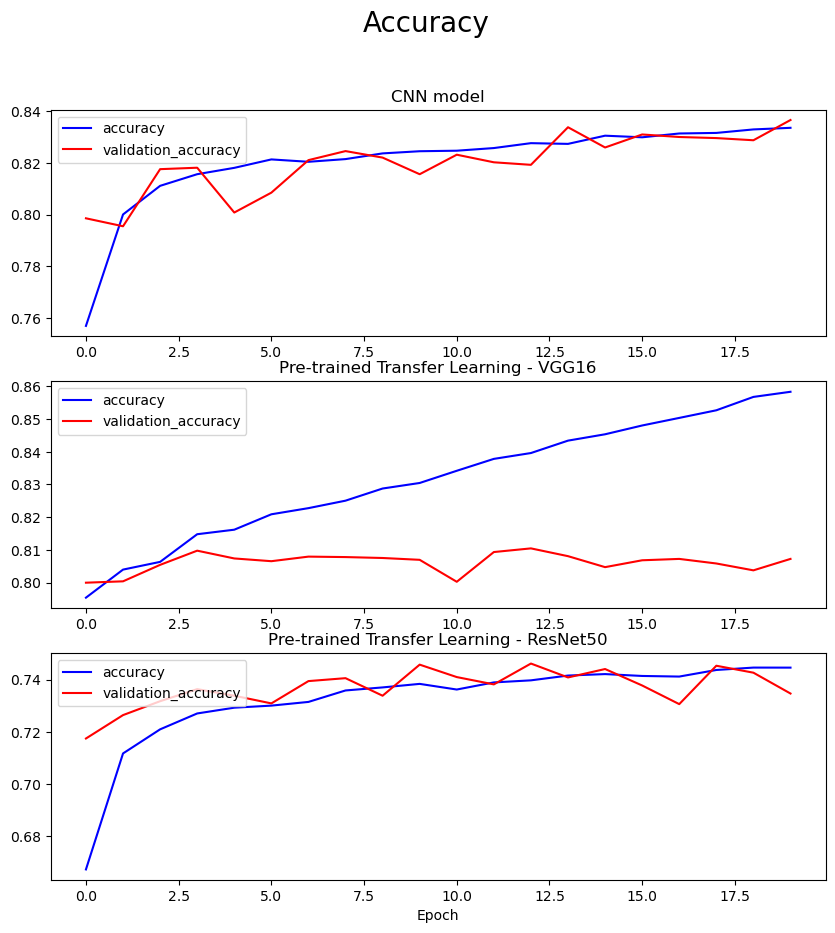

In [179]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

ax1.plot(history.history['accuracy'], color='blue', label='accuracy')
ax1.plot(history.history['val_accuracy'], color='red', label='validation_accuracy')

ax2.plot(history_vgg16.history['accuracy'], color='blue', label='accuracy')
ax2.plot(history_vgg16.history['val_accuracy'], color='red', label='validation_accuracy')

ax3.plot(history_resnet.history['accuracy'], color='blue', label='accuracy')
ax3.plot(history_resnet.history['val_accuracy'], color='red', label='validation_accuracy')

ax1.set_title("CNN model")
ax2.set_title("Pre-trained Transfer Learning - VGG16")
ax3.set_title("Pre-trained Transfer Learning - ResNet50")

ax1.legend(loc="upper left")
ax2.legend(loc="upper left")

plt.xlabel('Epoch')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.savefig('accuracy-3-models.png')

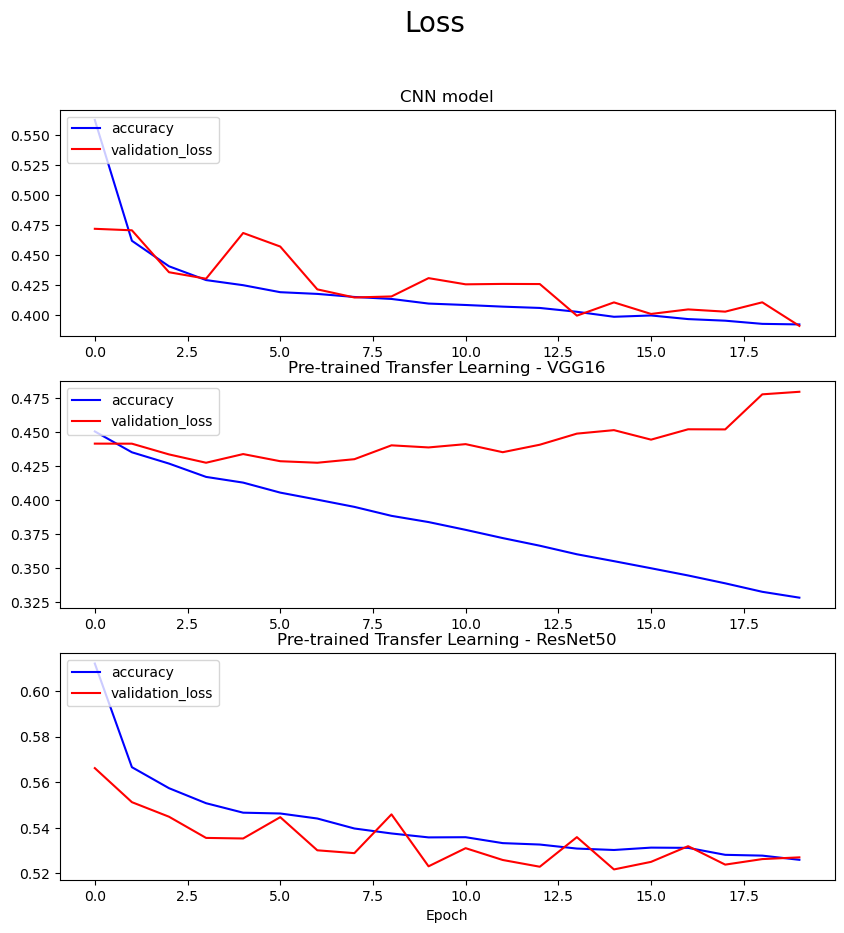

In [180]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

ax1.plot(history.history['loss'], color='blue', label='accuracy')
ax1.plot(history.history['val_loss'], color='red', label='validation_loss')

ax2.plot(history_vgg16.history['loss'], color='blue', label='accuracy')
ax2.plot(history_vgg16.history['val_loss'], color='red', label='validation_loss')

ax3.plot(history_resnet.history['loss'], color='blue', label='accuracy')
ax3.plot(history_resnet.history['val_loss'], color='red', label='validation_loss')

ax1.set_title("CNN model")
ax2.set_title("Pre-trained Transfer Learning - VGG16")
ax3.set_title("Pre-trained Transfer Learning - ResNet50")

ax1.legend(loc="upper left")
ax2.legend(loc="upper left")

plt.xlabel('Epoch')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.savefig('loss-3-models.png')

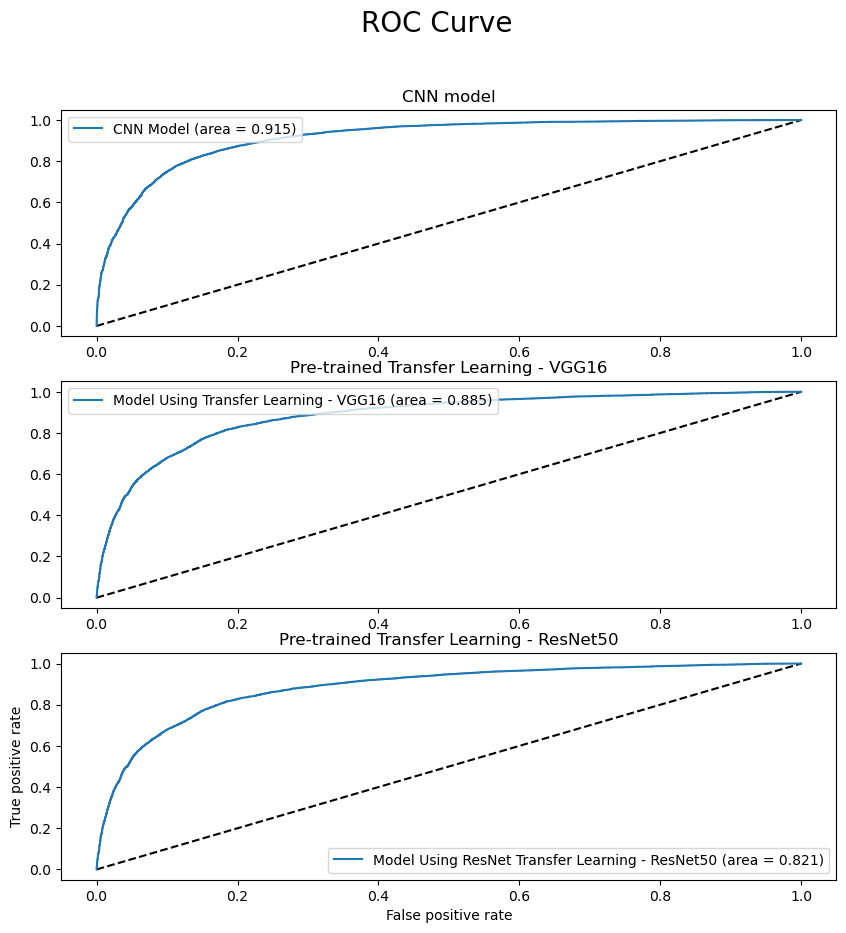

In [182]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

ax1.plot([0, 1], [0, 1], 'k--')
ax1.plot(fpr, tpr, label='CNN Model (area = {:.3f})'.format(auc_model1))

ax2.plot([0, 1], [0, 1], 'k--')
ax2.plot(fpr2, tpr2, label='Model Using Transfer Learning - VGG16 (area = {:.3f})'.format(auc_model_vgg16))

ax3.plot([0, 1], [0, 1], 'k--')
ax3.plot(fpr2, tpr2, label='Model Using ResNet Transfer Learning - ResNet50 (area = {:.3f})'.format(auc_model_resnet))


ax1.set_title("CNN model")
ax2.set_title("Pre-trained Transfer Learning - VGG16")
ax3.set_title("Pre-trained Transfer Learning - ResNet50")

ax1.legend(loc="upper left")
ax2.legend(loc="upper left")

plt.xlabel('Epoch')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
fig.suptitle('ROC Curve', fontsize=20)
plt.legend(loc='best')
plt.savefig('ROC-curve3-models.png')